## Functions used for plotting data for atn_resilience.
See atn_analysis for functions to create processed data.

In [1]:
import os
dir_path = os.getcwd()
# dir_path = os.path.dirname(os.getcwd())
script_dir = dir_path + '/atnresilience'
os.chdir(script_dir)

import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import calendar
from mpl_toolkits.basemap import Basemap
import networkx as nx
from sqlalchemy import *

import atn_visualization
import atn_tools
import db_tools

In [2]:
#Create the paths for the graphs to be saved to
#dir_path is the path to the main directory
db_path = '%s/data/processed/atn_db.sqlite' %(dir_path,)
processed_direc = '%s/data/processed/'%(dir_path,)
graph_direc = '%s/data/graph/'%(dir_path,)

## Declare common input variables used for analysis

In [3]:
start_year = 2015
end_year = 2017
airline_list = ['ALL','AA','DL','UA','WN']
include_data = 'ADM'
year_list = list(range(start_year, end_year+1))

## Create M-D Rolling Mean Plot
Use the data that was created from the M-D calculations to create a plot of the rolling mean of M-D data. Multiple airlines will be plotted on a single graph over a period of multiple years.

Mahalanobis Distance calculations must be done for the years and airlines desired before graphing. See atnresilience_analysis

The graphs will be saved in the "atnresilience/processed/graph" directory.

Graph saved to: /Users/allen/Documents/atnresilience/data/graph/md_rolling_mean.pdf


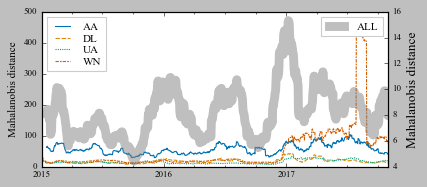

In [4]:
mean_direc = '%smd_rolling_mean.pdf' %(graph_direc,)

atn_visualization.rolling_mean_plot(year_list, airline_list, include_data, processed_direc, 'md')
# atn_visualization.md_rolling_mean_plot(mean_year_range, mean_window, mean_airline_list, mean_include_data, # processed_direc)

plt.savefig(mean_direc, dpi = 300)
print('Graph saved to: %s' %(mean_direc,))

## Create Raw Delay Rolling Mean Plot
Create the rolling mean of the average delay for each airline on each day across its entire network of filtered flights.

Graph saved to: /Users/allen/Documents/atnresilience/data/graph/delay_rolling_mean_new.pdf


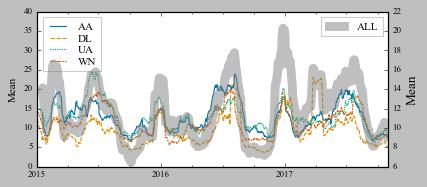

In [4]:
delay_rm_direc = '%sdelay_rolling_mean.pdf' %(graph_direc,)

atn_visualization.rolling_mean_plot(year_list,airline_list,include_data,processed_direc,'delay',y_upper = 40)

plt.savefig(delay_rm_direc, dpi = 300,transparent=True)
print('Graph saved to: %s' %(delay_rm_direc,))

## Create Median Quantile Plot
Use the data that was created from the M-D calculations to create a plot of the median of M-D data. Multiple airlines will be plotted on a single graph over a period of multiple years.

Mahalanobis Distance calculations must be done for the years and airlines desired before graphing. See atnresilience_analysis

The graphs will be saved in the "atnresilience/processed/graph" directory.

/Users/allen/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
Graph saved to: /Users/allen/Documents/atnresilience/data/graph/md_median_quantile.pdf


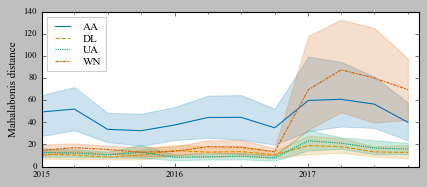

In [9]:
# quantile_year_range =  list(range(quantile_min_year, quantile_max_year+1))
quantile_filepath = '%smd_median_quantile.pdf' %(graph_direc,)

atn_visualization.md_median_lineplot(year_list, airline_list, include_data, processed_direc)
plt.savefig(quantile_filepath, dpi = 300)
print('Graph saved to: %s' %quantile_filepath)

## Create the IAPL Rolling Mean Plot

Rolling mean for the network approach inverse average path length. Window is set to 31 days (centered)

Graph saved to: /Users/allen/Documents/atnresilience/data/graph/iapl_rolling_mean.pdf


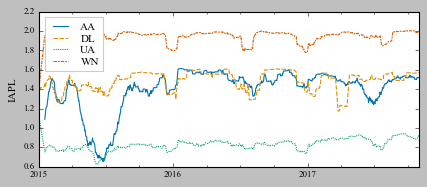

In [8]:
iapl_rm_window = 31
iapl_rm_filepath = '%siapl_rolling_mean.pdf' %(graph_direc,)

atn_visualization.iapl_rolling_mean_plot(year_list, iapl_rm_window, airline_list, processed_direc)

plt.savefig(iapl_rm_filepath, dpi = 300, Transparent=True)
print('Graph saved to: %s' %iapl_rm_filepath)

## Create US Map Plot of Airline Operation Data

Nodes and edges are weighted by number of flights.

Currently not possible to plot "ALL" unless airports are dropped as some airports in the dataset are no in the airport coordinates file.

Map saved to /Users/allen/Documents/atnresilience/data/graph/WN_2017_operational_map.pdf


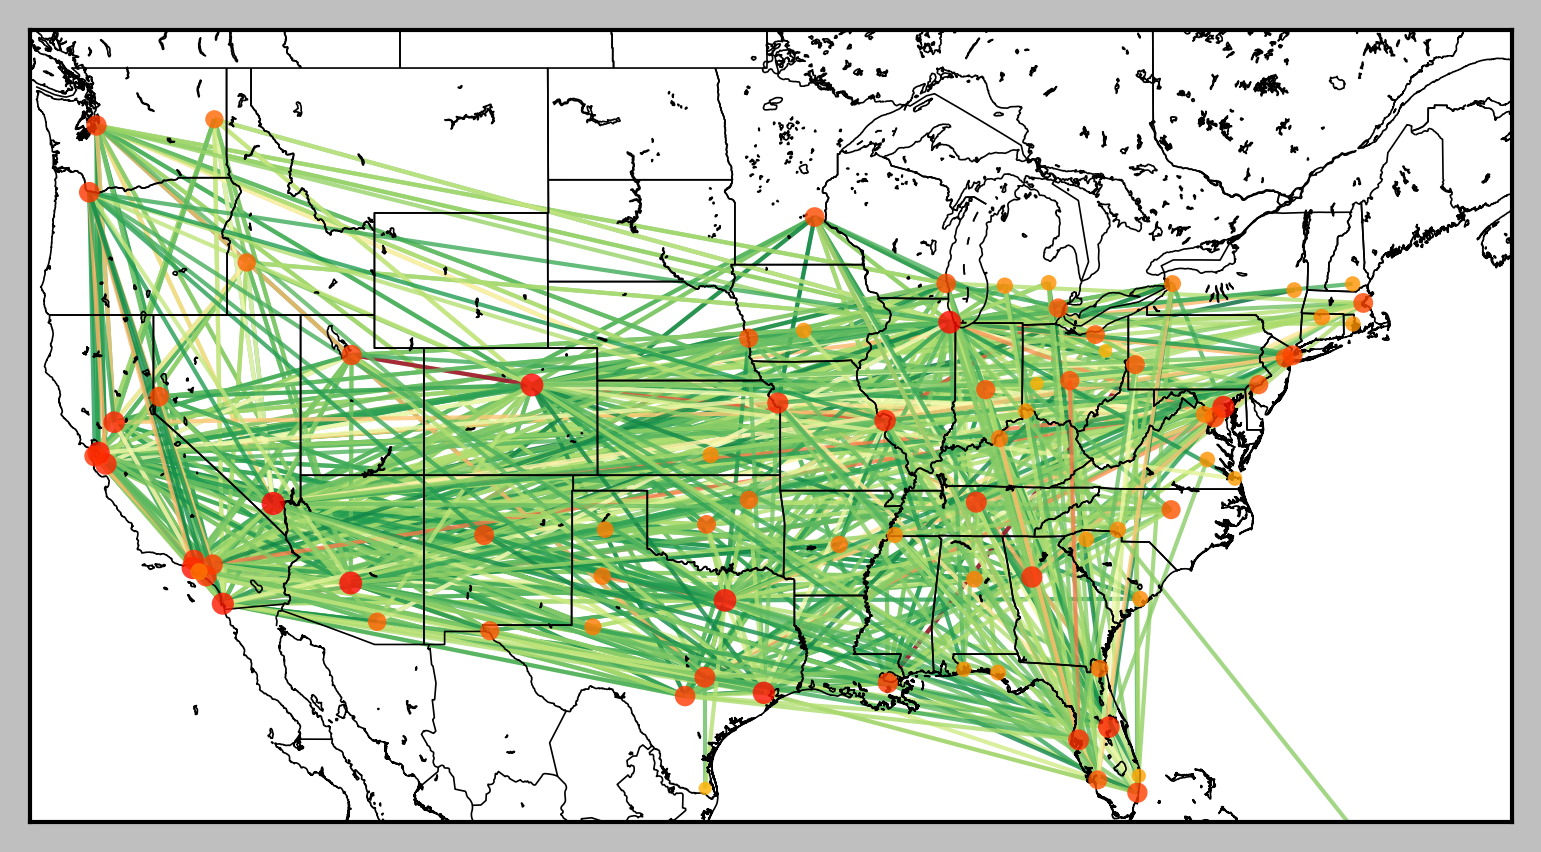

In [4]:
db_queries = db_tools.DBQueries()
airline_list = ['WN']
year_list = [2017]
sql = ''' 
    SELECT Destination_Airport_Code AS Destination, Origin_Airport_Code AS Origin
    FROM atn_performance
    WHERE Destination_Airport_Code IN (
        SELECT Destination_Airport_Code
        FROM atn_performance
        WHERE Year = :year
        AND Unique_Carrier_ID LIKE :airline
        AND Can_Status != 1 AND Div_Status != 1 
        GROUP BY Destination_Airport_Code
        HAVING COUNT(DISTINCT(Day_Of_Year)) = :days_in_year
        )
    AND Year = :year
    AND Unique_Carrier_ID LIKE :airline
    AND Can_Status != 1 AND Div_Status != 1 
    '''
for airline in airline_list:
    query_airline = airline
    if airline=='ALL' or airline=='':
        query_airline = '%'

    for year in year_list:
        days_in_year = 365
        if calendar.isleap(year):
            days_in_year = 366
            
        airline_df = db_queries.query_to_df(sql,params={'year' : year, 'days_in_year' : days_in_year,'airline' : query_airline})

        # Get the occurences of each unique edge/route and weight the values
        edge_df = airline_df.groupby(['Origin','Destination']).size().reset_index(name='Count')
        edge_df['Weight'] = edge_df['Count'].apply(np.log10)

        # Get the occurences of each Origin airport and weight the values
        node_df = airline_df.groupby(['Origin']).size().reset_index(name='Count')
        node_df['Weight'] = node_df['Count'].apply(np.log10)
        node_dict =  dict(zip(node_df['Origin'],node_df['Weight']))
        # node_dict = node_df.set_index('Origin')['Weight'].to_dict()

        atn_visualization.us_map_plot(db_path, processed_direc, year, graph_direc, airline, node_dict, edge_df, 
        graph_name='operational')


## Create the US Network Removals Visualization Plot
Using the data from the weighted edge and removal frequency functions, plot the nodes (airports) and the edges (airline routes). 

The plot only shows one airline for a specific year. It utilizes the Basemap toolkit from Matplotlib.

Currently not possible to plot "ALL" unless airports are dropped as some airports in the dataset are no in the airport coordinates file.

Map saved to /Users/allen/Documents/atnresilience/data/graph/WN_2017_removals_map.pdf
Map saved to /Users/allen/Documents/atnresilience/data/graph/UA_2017_removals_map.pdf


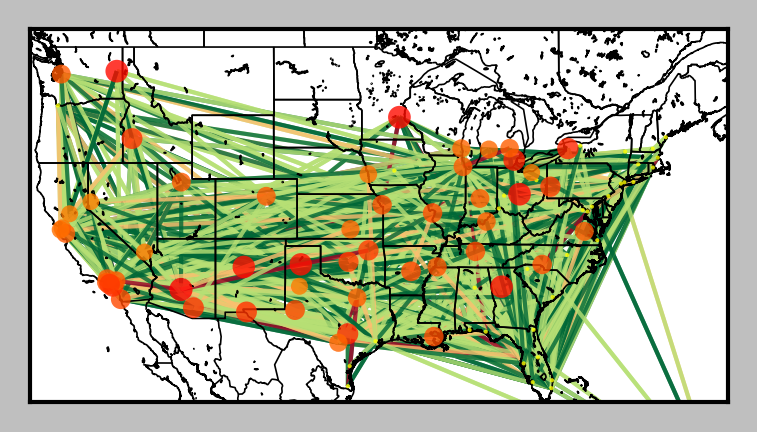

<Figure size 640x480 with 0 Axes>

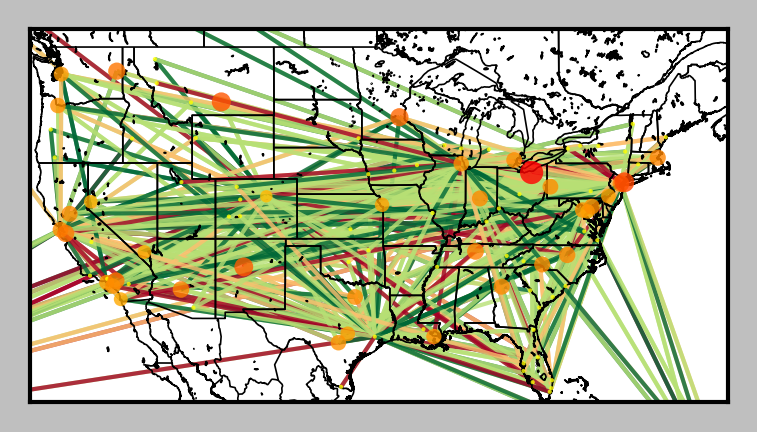

<Figure size 640x480 with 0 Axes>

In [4]:
can_limit = 0.1
zs_limit = 0.95
rep_num = 50
removals_map_airline_list = ['WN','UA']
removals_map_year_list = [2017]
for airline in removals_map_airline_list:
        for year in removals_map_year_list:
                removals = atn_tools.remove_frequency(db_path, year, airline, include_data, can_limit, zs_limit,processed_direc)
                edges = atn_tools.weighted_edge(db_path,year, airline)
                try:
                        atn_visualization.us_map_plot(
                                db_path,
                                processed_direc,
                                year,
                                graph_direc,
                                airline,
                                removals,
                                edges,
                                graph_name='removals',
                                show_plot=False)
                except KeyError:
                        print('Node not found for %s %s'%(airline,year))
                        continue
                except:
                        print('Unexpected error')
                        continue

## Create plots of the network metrics based on random removals

/Users/allen/Documents/atnresilience/atnresilience/atn_visualization.py:366: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  CS_df_airline = pd.concat([CS_df_airline,CS_quant_calc],ignore_index=True)
/Users/allen/Documents/atnresilience/atnresilience/atn_visualization.py:371: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  IAPL_df_airline = pd.concat([IAPL_df_airline,IAPL_quant_calc],ignore_index=True)
/Users/allen/Documents/atnresilience/atnresilience/atn_visualization.py:376: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of

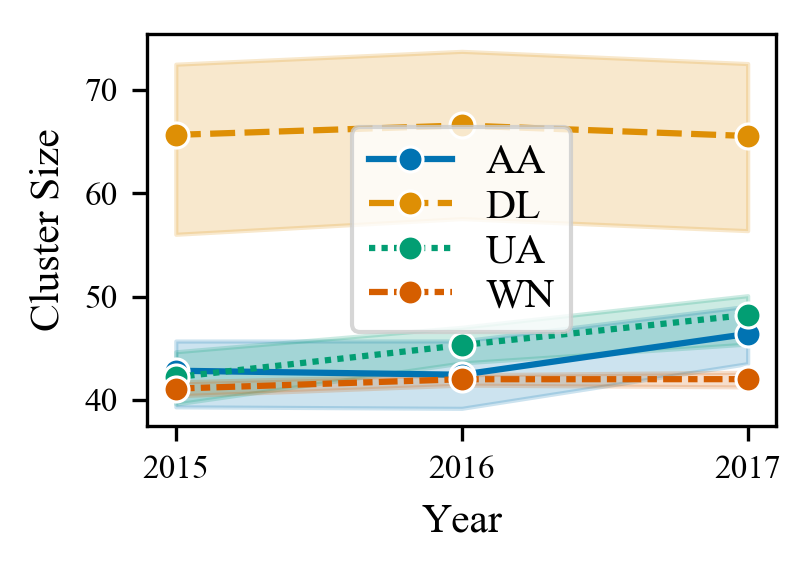

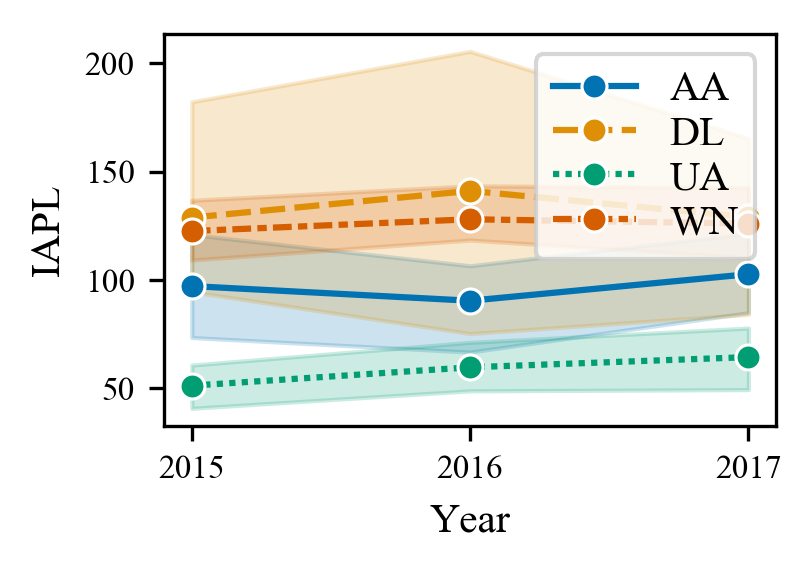

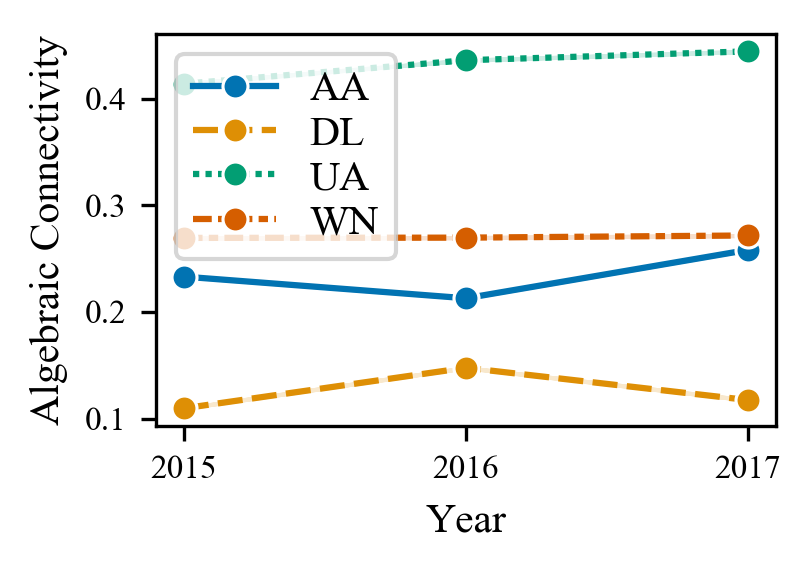

In [4]:
atn_visualization.ran_remove_shaded(year_list,airline_list,processed_direc,graph_direc)

# Functions beyond this were not used for the paper

## Create Raw Delay Mean Plot

Create a plot of the average delay for each airline on each day of the year

Graph saved to: /Users/allen/Documents/atnresilience/data/graph/raw_delay_mean.pdf


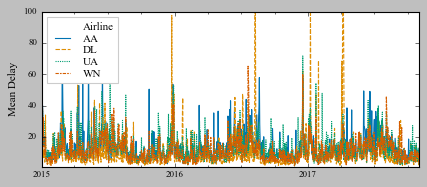

In [6]:
delay_direc = '%sraw_delay_mean.pdf' %(graph_direc,)

atn_visualization.delay_mean_plot(year_list,airline_list,processed_direc)
plt.savefig(delay_direc, dpi = 300)
print('Graph saved to: %s' %(delay_direc,))

## Create the Cluster Size Rolling Mean Plot

In [9]:
#Define parameters for the mean plots
#define year range
cs_rm_min_year = 2015
cs_rm_max_year = 2017

cs_rm_include_data = 'ADM'

cs_rm_airline_list = ['AA','DL','UA','WN']

cs_rm_window = 31

Graph saved to: /Users/allen/Documents/atnresilience/data/graph/cs_rolling_mean.pdf


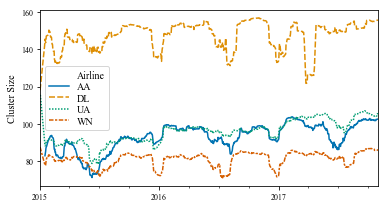

In [10]:
cs_rm_year_range =  list(range(iapl_rm_min_year, iapl_rm_max_year+1))
cs_rm_direc = '%scs_rolling_mean.pdf' %(graph_direc,)

atn_visualization.cs_rolling_mean_plot(cs_rm_year_range, cs_rm_window, cs_rm_airline_list, processed_direc)

plt.savefig(cs_rm_direc, dpi = 350)
print('Graph saved to: %s' %(cs_rm_direc,))

## Create the Hurricane Matthews Plot
Use the data that was created from the MD calculations and plot each year. Multiple airlines can be plotted for a single year. 

The graphs will be saved in the "atnresilience/processed/graph" directory.

In [3]:
#Specify year ranges to analyze
matt_year = 2016

#Specify the data dropping method
matt_include_data = 'ADM'

#Specify which airline to analyze. To do all airlines, put 'ALL'
matt_airlines = ['ALL','AA','DL','UA','WN']

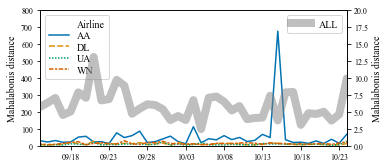

In [4]:
atn_visualization.hurr_matt(matt_year, matt_airlines, matt_include_data, processed_direc)
matt_graph_name = '%smd_matthew_plot.pdf' %(graph_direc)
plt.savefig(matt_graph_name, bbox_inches='tight',dpi = 300)

## Create the Hurricane Harvey MD Plot

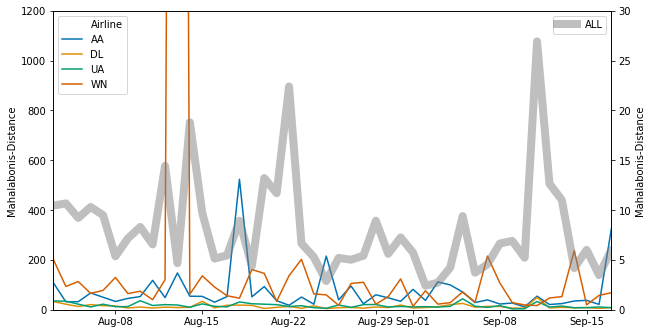

In [13]:
#Specify year ranges to analyze
harv_year = 2017

#Specify the data dropping method
harv_include_data = 'ADM'

#Specify which airline to analyze. To do all airlines, put 'ALL'
harv_graph_airlines = ['ALL','AA','DL','UA','WN']

atn_visualization.hurr_harvey(harv_year, harv_graph_airlines, harv_include_data, processed_direc)
graph_name = '%smd_harvey_plot.pdf' %(graph_direc)
plt.savefig(graph_name, bbox_inches='tight',dpi = 300)

## Create the Hurricane Matthew IAPL Rolling Mean Plot

Graph saved to: /Users/allen/Documents/atnresilience/data/graph/iapl_matthew_plot.pdf


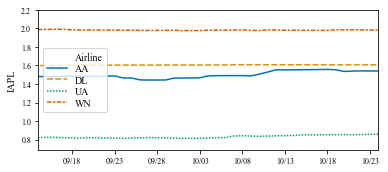

In [13]:
matt_iapl_year = [2016]
matt_iapl_airlines = ['AA','DL','UA','WN']

atn_visualization.iapl_matthew(matt_iapl_year, 31, matt_iapl_airlines, processed_direc)

matt_iapl_name = '%siapl_matthew_plot.pdf' %(graph_direc)
plt.savefig(matt_iapl_name, bbox_inches='tight',dpi = 300)
print('Graph saved to: %s'%(matt_iapl_name))

In [3]:
ran_min_year = 2015
ran_max_year = 2017
ran_airline_list = ['AA','DL','UA','WN']

## Create the Hurricane Matthew Cluster Size Rolling Mean Plot

In [ ]:
matt_cs_year = [2016]
matt_cs_airlines = ['AA','DL','UA','WN']

atn_visualization.cs_matthew(matt_cs_year, 31, matt_cs_airlines, processed_direc)

matt_cs_name = '%scs_matthew_plot.eps' %(graph_direc)
plt.savefig(matt_cs_name, bbox_inches='tight',dpi = 300)

## Create MD Median Plot
Plot the median of MD data over a range of years.

MD_med_min_year = 2007
MD_med_max_year = 2017

MD_med_year_range =  list(range(MD_med_min_year, MD_med_max_year+1))

median_include_data = 'ADM'

median_airline_list = ['ALL']

fignum = 0
for airline in median_airline_list:
    plt.figure(fignum)
    atn_visualization.md_median_plot(MD_med_year_range, airline, median_include_data, processed_direc)
    graph_name = '%sMD Median %s %s %s Plot.png' %(graph_direc,airline,MD_med_min_year,MD_med_max_year)
    plt.savefig(graph_name, bbox_inches='tight',dpi = 1500)
    fignum += 1

## Create Distribution Plot
Create a distribution plot of the Mahlanobis-Distance Data
The type of distribution plot can be specified: <br>
'kdeplot' <br>
'boxplot'

#Define parameters for the distribution plots
#define year range
distribution_min_year = 2014
distribution_max_year = 2017

distribution_include_data = 'ADM'

distribution_airline_list = ['AA']

distribution_plot_type = 'kdeplot'

distribution_year_range =  list(range(distribution_min_year, distribution_max_year+1))

for year in distribution_year_range: 
    atn_visualization.md_disitrbution_plot(year, distribution_airline_list, distribution_plot_type, distribution_include_data, processed_direc)

## Create the IAPL Median Plot

In [7]:
#Define parameters for the line plots
#define year range
iapl_med_min_year = 2015
iapl_med_max_year = 2017

iapl_med_include_data = 'ADM'

#To plot the whole network, use 'ALL'. All will be plotted with a different scale displayed on the right-hand y-axis
iapl_med_airline_list = ['AA','DL','UA','WN']

/Users/allen/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Graph saved to: /Users/allen/Documents/atnresilience/data/graph/iapl_med_plot.png


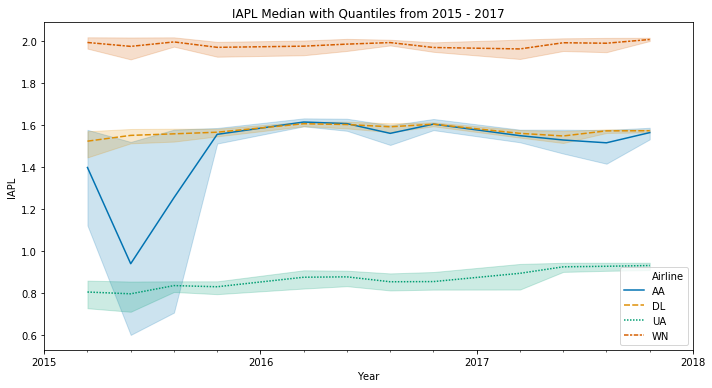

In [8]:
iapl_med_year_range =  list(range(iapl_med_min_year, iapl_med_max_year+1))
iapl_med_direc = '%siapl_med_plot.eps' %(graph_direc,)

atn_visualization.iapl_median_lineplot(iapl_med_year_range, iapl_med_airline_list, processed_direc)

plt.savefig(iapl_med_direc, dpi = 300)
print('Graph saved to: %s' %(iapl_med_direc,))